In [ ]:
# test realtime setup
import timeit

def process_data(calibration_stage = False):
    if (calibration_stage):
        #clear initial bullshit data
        for i in range(10):
            incoming_message = c.recv(1024).decode("utf-8")
        
    incoming_message = c.recv(512).decode("utf-8") #Collect data from port and decode into  string
    data_start_ix = incoming_message.find("[")
    data_end_ix = incoming_message.find("]")
    data_found = (data_start_ix != -1) and (data_end_ix != -1) and (data_start_ix < data_end_ix)

    while(not data_found):
        incoming_message = c.recv(512).decode("utf-8") #Collect data from port and decode into  string
#         print("data not found")
        data_start_ix = incoming_message.find("[")
        data_end_ix = incoming_message.find("]")
        data_found = (data_start_ix != -1) and  (data_end_ix != -1) and (data_start_ix < data_end_ix)
#         print("data_start_ix,data_end_ix",data_start_ix,data_end_ix)
        
    incoming_message = incoming_message[data_start_ix+1 : data_end_ix] 
    incoming_message = incoming_message.replace(',','.')
    list_matrix = incoming_message.split(";")

    right_hand = to_right_CS(np.fromstring(list_matrix[0], dtype=np.float,sep =" ").reshape((4,4)))
    left_hand = to_right_CS(np.fromstring(list_matrix[1], dtype=np.float,sep =" ").reshape((4,4)))
    
#     check_boolshit = np.linalg.norm(right_hand[:3,3]) > 0.01 and np.linalg.norm(left_hand[:3,3]) > 0.01
#     if (not check_boolshit): print("boolshit check is not passed")

    return right_hand, left_hand
    
def test_pipeline():
    right_track_ini,left_track_ini = process_data(True)
    dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)
        
    wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                        dir_to_wrist_in_AL,
                                                                        length_l_wrist,
                                                                        length_l_elbow)

    shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                    dir_to_wrist_in_AL,
                                                    length_r_shoulder)

    right_track_ini = tf2robot @ right_track_ini
    left_track_ini = tf2robot @ left_track_ini

    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                         elbow_in_left_tracker_CS,
                       shoulder_in_right_tracker_CS,
                       left_track_ini,
                       right_track_ini)

    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])

    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])

    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)

    for i in range (10000):
        right_track_ini ,left_track_new = process_data()
        right_track_ini = tf2robot @ right_track_ini
        left_track_new = tf2robot @ left_track_new
        x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                       elbow_in_left_tracker_CS,
                       shoulder_in_right_tracker_CS,
                       left_track_new,
                       right_track_ini)

        start_point_f = np.array([x[1],y[1],z[1]])
        end_point_f  = np.array([x[0],y[0],z[0]])
        point_on_cylinder_f = left_track_new[:3,3]

        start_point_u = np.array([x[2],y[2],z[2]])
        end_point_u  = np.array([x[1],y[1],z[1]])
        point_on_cylinder_u = right_track_ini[:3,3]

        xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
        xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)


radial_density = 10
height_density = 10
    
s = socket.socket()

print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)
print("waiting for calc start")
keyboard.wait('esc')
print(" calc has started")
time_elapsed = timeit.timeit("test_pipeline()", setup="from __main__ import test_pipeline", globals=locals(),number = 1) 
print("radial = " ,radial_density,"height = ", height_density, "time_elapsed" ,time_elapsed,"dt ms = ", time_elapsed/10 )


socket created 
socket binded to port 
socket listensing ... 

got connection from  ('127.0.0.1', 56976)
waiting for calc start


In [1]:
# functions and constants initialization
import time, serial
import sys
import urx
import numpy as np
import keyboard
import json, math
from numpy.linalg import inv
import os
from scipy import stats
import  socket
from IPython.display import clear_output
from _thread import *
import threading


from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from scipy.spatial.transform import Rotation as R

# constants initialization
# multiplication from left moves to robot cs
tf2robot = np.array([[0,0,1,-150/1000],[1,0,0,800/1000],[0,1,0,-2800/1000],[0,0,0,1]],dtype = np.float32)
tf2Antilat = np.linalg.inv(tf2robot)

#flips z coordinate to transform left-handed CS to the right-handed one
def to_right_CS (tf_in_left_cs):
    if tf_in_left_cs.shape != (4,4):
        raise
    tf_in_right_cs = tf_in_left_cs.copy()
    tf_in_right_cs[2,:] = -1 * tf_in_left_cs[2,:]
    
    return tf_in_right_cs

def get_direction_to_wrist_in_AL(left_track_ini_in_AL_CS,right_track_ini_in_AL_CS,forearm_radius,upper_arm_radius):
    
    dir_to_wrist_in_AL = np.array([0,0,0],dtype = np.float32)
    
    z_dir_forearm = left_track_ini_in_AL_CS[:3,2]
    z_shift_forearm_in_AL = - forearm_radius *  z_dir_forearm/np.linalg.norm(z_dir_forearm)
    
    z_dir_upperarm = right_track_ini_in_AL_CS [:3,2]
    z_shift_upperarm_in_AL = - upper_arm_radius *  z_dir_upperarm/np.linalg.norm(z_dir_upperarm)
    
    center_of_forearm_in_AL_CS = left_track_ini_in_AL_CS[:3,3] + z_shift_forearm_in_AL
    
    center_of_upperarm_in_AL_CS = right_track_ini_in_AL_CS[:3,3] + z_shift_upperarm_in_AL
    
    dir_to_wrist_in_AL = center_of_forearm_in_AL_CS - center_of_upperarm_in_AL_CS
    dir_to_wrist_in_AL = dir_to_wrist_in_AL/np.linalg.norm(dir_to_wrist_in_AL)
    
    return dir_to_wrist_in_AL

def get_forearm_tfs(left_track_ini_in_AL_CS,dir_to_wrist_in_AL,length_l_wrist,length_l_elbow):
    
    dir_to_elbow_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_elbow_in_AL = -1 * dir_to_wrist_in_AL
    
    wrist_in_AL_CS = np.eye(4,dtype = np.float32)
    elbow_in_AL_CS = np.eye(4,dtype = np.float32)

    #z_axis is directed from the hand  
    wrist_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_wrist * dir_to_wrist_in_AL
    elbow_in_AL_CS[:3,3] = left_track_ini_in_AL_CS[:3,3] + length_l_elbow * dir_to_elbow_in_AL
    wrist_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ wrist_in_AL_CS
    elbow_in_left_tracker_CS = np.linalg.inv(left_track_ini_in_AL_CS) @ elbow_in_AL_CS
    
    return wrist_in_left_tracker_CS,elbow_in_left_tracker_CS

def get_upperarm_tf(right_track_ini_in_AL_CS,dir_to_wrist_in_AL, length_r_shoulder):
    
    dir_to_shoulder_in_AL = dir_to_wrist_in_AL.copy()
    dir_to_shoulder_in_AL = -1 * dir_to_wrist_in_AL

    shoulder_in_AL_CS = np.eye(4,dtype = np.float32)
    shoulder_in_AL_CS[:3,3] = right_track_ini_in_AL_CS[:3,3] + length_r_shoulder * dir_to_shoulder_in_AL 
   
    shoulder_in_right_tracker_CS = np.linalg.inv(right_track_ini_in_AL_CS) @ shoulder_in_AL_CS 
#     shoulder_in_right_tracker_CS[:3,3] = shoulder_in_right_tracker_CS[:3,3] + z_shift_upper_arm_CS
    
    return shoulder_in_right_tracker_CS

def calc_all_tfs(tf_2_wrist_in_forearm_CS,
                   tf_2_elbow_in_forearm_CS,
                   tf_2_shoulder_in_upperarm_CS,
                   left_hand_R,
                   right_hand_R):
    
    new_wrist = left_hand_R @ tf_2_wrist_in_forearm_CS
    new_elbow = left_hand_R @ tf_2_elbow_in_forearm_CS
    new_shoulder = right_hand_R @ tf_2_shoulder_in_upperarm_CS
    x_new = np.array([new_wrist[0,3],new_elbow[0,3],new_shoulder[0,3]]) 
    y_new = np.array([new_wrist[1,3],new_elbow[1,3],new_shoulder[1,3]]) 
    z_new = np.array([new_wrist[2,3],new_elbow[2,3],new_shoulder[2,3]]) 
    
    return x_new,y_new,z_new


# the distance from trackers to elbow, wrist,and shoulder
length_l_wrist = 350/1000 # mm
length_l_elbow = 80/1000 # mm
length_r_elbow = 100/1000
length_r_shoulder = 150/1000
#####
# estimated arm params
forearm_radius = 55/1000
upper_arm_radius = 60/1000
whrist_radius = 50/1000
shoulder_radius = 50/1000
#####
def cylinder_generation(start_point,end_point,radius,radial_density,height_density):
    dz =  (end_point - start_point)/ (height_density-1)
    dTheta = 2 * np.pi / radial_density
    dz_norm = dz / np.linalg.norm(dz)
    
    eps = 1e-3
    other_vector = dz + np.array([1.0,1.0, 1.0])
    check_collinearity = np.abs(np.linalg.norm(np.cross(dz,other_vector))) < eps 
    
    if (not check_collinearity): other_vector = dz + np.array([1.0,1.0, 1.0])
    vec_to_surface = np.cross(dz, other_vector - start_point)

    
    start_point_on_surface = vec_to_surface / (np.linalg.norm(vec_to_surface)) * radius
    rot_matrix = R.from_rotvec(dTheta * dz_norm).as_matrix()
    all_points = np.empty((radial_density * height_density,3))
    
    #generate points relative to the CS origin
    for i in range(height_density):
        all_points[i*radial_density,:] = start_point_on_surface
        for j in range(1,radial_density):
            start_point_on_surface = rot_matrix @ start_point_on_surface
            all_points[i*radial_density + j,:] = start_point_on_surface
        start_point_on_surface += dz
        
    #shift points to start point
    for point in all_points:
        point += start_point 
    
    return all_points[:,0],all_points[:,1],all_points[:,2]

def update_points_realtime(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
    global forearm_radius, upper_arm_radius
    global tf2robot
    right_track_ini ,left_track_new = process_data()
    right_track_ini = tf2robot @ right_track_ini
    left_track_new = tf2robot @ left_track_new
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]

    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt

# parsing tfs, switch to right-hand CS
#be carefull with the decode function
def process_data(calibration_stage = False):
    if (calibration_stage):
        #clear initial bullshit data
        for i in range(10):
            incoming_message = c.recv(1024).decode("utf-8")
        
    incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
    data_start_ix = incoming_message.find("[")
    data_end_ix = incoming_message.find("]")
    data_found = (data_start_ix != -1) and (data_end_ix != -1) and (data_start_ix < data_end_ix)

    while(not data_found):
        incoming_message = c.recv(1024).decode("utf-8") #Collect data from port and decode into  string
#         print("data not found")
        data_start_ix = incoming_message.find("[")
        data_end_ix = incoming_message.find("]")
        data_found = (data_start_ix != -1) and  (data_end_ix != -1) and (data_start_ix < data_end_ix)
#         print("data_start_ix,data_end_ix",data_start_ix,data_end_ix)
        
    incoming_message = incoming_message[data_start_ix+1 : data_end_ix] 
    incoming_message = incoming_message.replace(',','.')
    list_matrix = incoming_message.split(";")

    right_hand = to_right_CS(np.fromstring(list_matrix[0], dtype=np.float,sep =" ").reshape((4,4)))
    left_hand = to_right_CS(np.fromstring(list_matrix[1], dtype=np.float,sep =" ").reshape((4,4)))
    
    check_boolshit = np.linalg.norm(right_hand[:3,3]) > 0.01 and np.linalg.norm(left_hand[:3,3]) > 0.01
    if (not check_boolshit): print("boolshit check is not passed")
#     print("left hand tf")
#     print(left_hand) 
#     print("right_hand")
#     print(right_hand)
    return right_hand, left_hand
    

socket created 
socket binded to port 
socket listensing ... 

got connection from  ('127.0.0.1', 60482)
writing calibration data


<IPython.core.display.Javascript object>


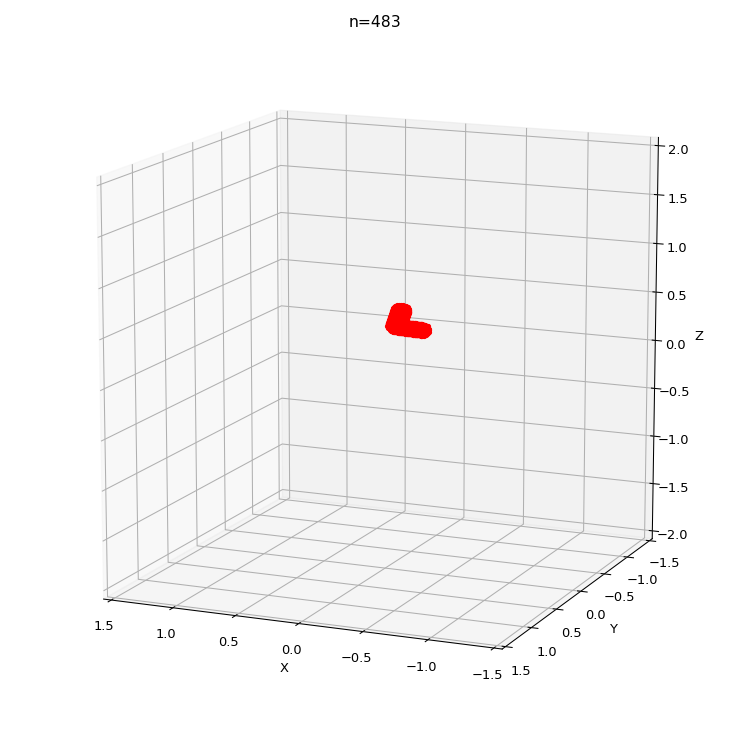

waiting for press data


In [2]:
%matplotlib notebook

s = socket.socket()

print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)
# print("writing calibration data")
# keyboard.wait('esc')

fig = plt.figure(figsize=(8,8))
ax = p3.Axes3D(fig)

ax.set_xlim3d([-1.5, 1.5])
ax.set_xlabel('X')

ax.set_ylim3d([-1.5, 1.5])
ax.set_ylabel('Y')

ax.set_zlim3d([-2.0, 2.0])
ax.set_zlabel('Z')

right_track_ini,left_track_ini = process_data(True)
dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)
        
wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    dir_to_wrist_in_AL,
                                                                    length_l_wrist,
                                                                    length_l_elbow)

shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                dir_to_wrist_in_AL,
                                                length_r_shoulder)

right_track_ini = tf2robot @ right_track_ini
left_track_ini = tf2robot @ left_track_ini

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)


points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 25
height_density = 25

start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

# print("waiting for press data")
# keyboard.wait('esc')

# while True:
right_track_new ,left_track_new = process_data()

ani=animation.FuncAnimation(fig,
                    update_points_realtime,
                    interval = 100,
                    save_count = 10,
                    fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_new))
plt.show()
# realtime update of points in 3D

<IPython.core.display.Javascript object>


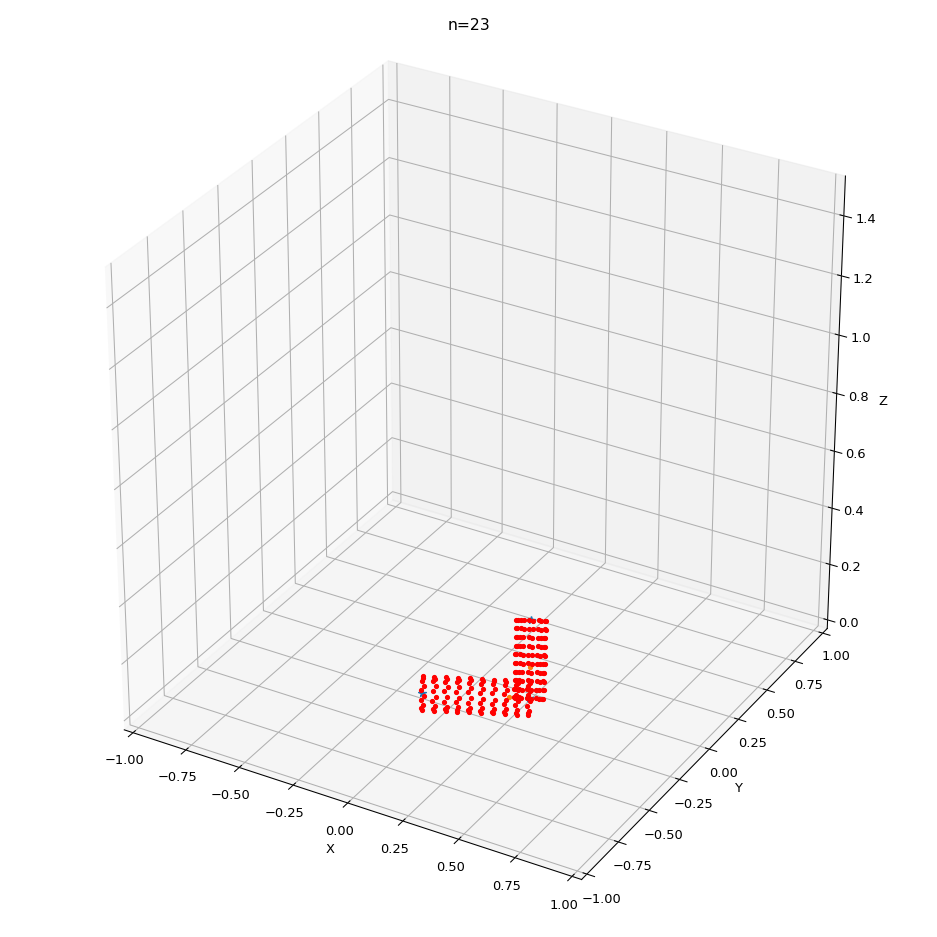

In [6]:

def get_test_vals():
    #setting calibrated poses
    xl,yl,zl = length_r_shoulder + length_l_elbow+length_r_elbow,0.0,0.0 #mm
    xr,yr,zr = length_r_shoulder, 0, 0 
    left_track_ini  = np.eye(4,dtype = np.float32)
    right_track_ini = np.eye(4,dtype = np.float32)
    left_track_ini[:3,3] = [xl,yl,zl] 
    right_track_ini[:3,3] = [xr,yr,zr]
    left_track_new = left_track_ini.copy()
    left_track_new[:3,3] = [xl-length_l_elbow ,yl + length_l_elbow,zl]
    left_track_new[:3,:3] = left_track_new[:3,:3] @ R.from_euler('z', 90, degrees=True).as_matrix()
    
    return left_track_ini,right_track_ini,left_track_new

def update_points(num, cyl_u,cyl_f, l,points,left_track_new,right_track_ini):
 
    global radial_density,height_density,shoulder_in_right_tracker_CS, wrist_in_left_tracker_CS,elbow_in_left_tracker_CS  
    global  forearm_radius, upper_arm_radius
    left_track_new = update(num,left_track_new)
    right_track_ini  = update(num,right_track_ini)
    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                   elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_new,
                   right_track_ini)
    txt.set_text('n={:d}'.format(num)) # for debug purposes
    points.set_data(x,y)
    points.set_3d_properties(z, 'z')
    
    l.set_data(np.array([right_track_ini[0,3],left_track_new[0,3]]),
               np.array([right_track_ini[1,3],left_track_new[1,3]]))
    l.set_3d_properties(np.array([right_track_ini[2,3],left_track_new[2,3]]), 'z')

    
    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_new[:3,3]
    
    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]
    
    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
    
    cyl_f.set_data(xc_f,yc_f)
    cyl_f.set_3d_properties(zc_f, 'z')
    
    cyl_u.set_data(xc_u,yc_u)
    cyl_u.set_3d_properties(zc_u, 'z')
    
    return cyl_u,cyl_f,l,points,txt

def update(num,input_tf):
    shift_tf,rot_tf,rot_tf_2 = np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32),np.eye(4,dtype=np.float32)
    shift_tf[:3,3] = [0.01*num,0*num,0.01*num]
    rot_tf[:3,:3] = R.from_euler('z', 5*num, degrees=True).as_matrix()
    rot_tf_2[:3,:3] = R.from_euler('y', 5*num, degrees=True).as_matrix()
    return shift_tf @ rot_tf @  rot_tf_2 @ input_tf

%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = p3.Axes3D(fig)

ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 1.5])
ax.set_zlabel('Z')

left_track_ini,right_track_ini,left_track_new = get_test_vals()

dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    dir_to_wrist_in_AL,
                                                                    length_l_wrist,
                                                                    length_l_elbow)

shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                dir_to_wrist_in_AL,
                                                length_r_shoulder)

x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                     elbow_in_left_tracker_CS,
                   shoulder_in_right_tracker_CS,
                   left_track_ini,
                   right_track_ini)

points, = ax.plot(x, y, z, '*')
txt = fig.suptitle('')
l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
             np.array([left_track_ini[1,3],right_track_ini[1,3]]),
             np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

radial_density = 10
height_density = 10
start_point_f = np.array([x[1],y[1],z[1]])
end_point_f  = np.array([x[0],y[0],z[0]])
point_on_cylinder_f = left_track_ini[:3,3]

start_point_u = np.array([x[2],y[2],z[2]])
end_point_u  = np.array([x[1],y[1],z[1]])
point_on_cylinder_u = right_track_ini[:3,3]

xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

ani=animation.FuncAnimation(fig,
                            update_points,
                            interval = 1000,
                            frames=100,
                            fargs=(cyl_u,cyl_f,l,points,left_track_new,right_track_ini))

plt.show()


In [17]:
import timeit

# Testing performance offline 
def test_pipeline():
    left_track_ini,right_track_ini,left_track_new = get_test_vals()

    dir_to_wrist_in_AL = get_direction_to_wrist_in_AL(left_track_ini,right_track_ini,forearm_radius,upper_arm_radius)

    wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                        dir_to_wrist_in_AL,
                                                                        length_l_wrist,
                                                                        length_l_elbow)

    shoulder_in_right_tracker_CS =  get_upperarm_tf(right_track_ini,
                                                    dir_to_wrist_in_AL,
                                                    length_r_shoulder)

    x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                         elbow_in_left_tracker_CS,
                       shoulder_in_right_tracker_CS,
                       left_track_ini,
                       right_track_ini)

    points, = ax.plot(x, y, z, '*')
    txt = fig.suptitle('')
    l, = ax.plot(np.array([left_track_ini[0,3],right_track_ini[0,3]]),
                 np.array([left_track_ini[1,3],right_track_ini[1,3]]),
                 np.array([left_track_ini[2,3],right_track_ini[2,3]]), '.')

    start_point_f = np.array([x[1],y[1],z[1]])
    end_point_f  = np.array([x[0],y[0],z[0]])
    point_on_cylinder_f = left_track_ini[:3,3]

    start_point_u = np.array([x[2],y[2],z[2]])
    end_point_u  = np.array([x[1],y[1],z[1]])
    point_on_cylinder_u = right_track_ini[:3,3]

    xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
    xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)
    cyl_f, = ax.plot(xc_f,yc_f ,zc_f, '.', color ='red')
    cyl_u, = ax.plot(xc_u,yc_u ,zc_u, '.', color ='red')

    for i in range (10000):
        left_track_new = update(i,left_track_new)
        right_track_ini  = update(i,right_track_ini)
        x,y,z = calc_all_tfs(wrist_in_left_tracker_CS,
                       elbow_in_left_tracker_CS,
                       shoulder_in_right_tracker_CS,
                       left_track_new,
                       right_track_ini)

        start_point_f = np.array([x[1],y[1],z[1]])
        end_point_f  = np.array([x[0],y[0],z[0]])
        point_on_cylinder_f = left_track_new[:3,3]

        start_point_u = np.array([x[2],y[2],z[2]])
        end_point_u  = np.array([x[1],y[1],z[1]])
        point_on_cylinder_u = right_track_ini[:3,3]

        xc_f,yc_f ,zc_f = cylinder_generation(start_point_f,end_point_f,forearm_radius,radial_density,height_density)
        xc_u,yc_u ,zc_u = cylinder_generation(start_point_u,end_point_u,upper_arm_radius,radial_density,height_density)

radial_density = 25
height_density = 25

time_elapsed = timeit.timeit("test_pipeline()", setup="from __main__ import test_pipeline", globals=locals(),number = 1) 
print("radial = " ,radial_density,"height = ", height_density, "time_elapsed" ,time_elapsed,"dt ms = ", time_elapsed/10 )

#results so far 
# radial_density =  5 height_density=  5 time_elapsed 7.228650900000048 dt ms =  0.7228650900000048
# radial =  10 height =  10 time_elapsed 11.613154699999996 dt ms =  1.1613154699999995
# radial =  25 height =  25 time_elapsed 42.53929940000012 dt ms =  4.2539299400000115
# radial =  50 height =  50 time_elapsed 153.9480023000001 dt ms =  15.39480023000001
# radial =  100 height =  100 time_elapsed 586.9668312000001 dt ms =  58.69668312000001


738.8643186


In [ ]:
#pipeline on a real setup

s = socket.socket()
print('socket created ')
port = 1234
s.bind(('127.0.0.1', port)) #bind port with ip address
print('socket binded to port ')
s.listen(5)#listening for connection
print('socket listensing ... ')

c, addr = s.accept() #when port connected
print("\ngot connection from ", addr)

print("writing calibration data")
right_hand_prev,left_hand_prev = processData()
keyboard.wait('esc')

wrist_in_left_tracker_CS,elbow_in_left_tracker_CS = get_forearm_tfs(left_track_ini,
                                                                    right_track_ini,
                                                                    length_l_wrist,
                                                                    length_l_elbow,
                                                                    forearm_radius)

shoulder_in_right_tracker_CS =  get_upperarm_tf(left_track_ini,
                                                right_track_ini,
                                                length_r_shoulder,
                                                upper_arm_radius)


while True:
        right_hand_new ,left_hand_new = processData()
        print("left hand tf")
        print(right_hand_new) 
        print("right_hand")
        print(left_hand_new)



In [ ]:
#test cyl generation

start_point = np.array([0,0,0])
end_point = np.array([0,1,0])
point_on_cylinder = np.array([0,0,1])
radial_density = 30
height_density = 10
x,y,z = cylinder_generation(start_point,end_point,point_on_cylinder,radial_density,height_density)

fig = plt.figure()
ax = p3.Axes3D(fig)
ax.set_xlim3d([-3.0, 3.0])
ax.set_xlabel('X')

ax.set_ylim3d([-2.0, 2.0])
ax.set_ylabel('Y')

ax.set_zlim3d([0.0, 5.0])
ax.set_zlabel('Z')

plot_points, = ax.plot(x, y, z, '*')
plt.show()